# Computing the betas

In order to compute the beta for both Stellantis and Walmart we took S&P 500 as benchmark.

To compute the beta for each company over the past 5 years, we will:

- Sort the data by date (in ascending order).

- Convert prices to monthly returns.

- Align returns by date across the 3 datasets.

- Perform linear regression of company returns on S&P 500 returns to compute beta.

### 4. **Run Linear Regressions**

To estimate beta for each stock, we run an Ordinary Least Squares (OLS) regression of the stock's returns against the market returns (S&P 500). The regression equation is:

                                                        r_stock = α + β * r_market + ε


Where:
- `r_stock` is the return of the stock (e.g., Walmart or Stellantis)
- `r_market` is the return of the market (S&P 500)
- `β` represents the stock’s **systematic risk** (sensitivity to the market)
- `α` is the intercept (often interpreted as abnormal return or "alpha")
- `ε` is the error term

The **slope coefficient (β)** from this regression is the **beta of the stock**. It tells us how much the stock’s return changes in response to changes in the market return.



In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

walmart_df = pd.read_csv('Dataset/Walmart Stock Price History.csv')
stellantis_df = pd.read_csv('Dataset/Stellantis NV Stock Price History.csv')
sp500_df = pd.read_csv('Dataset/S&P 500 Historical Data.csv')

for df in [walmart_df, stellantis_df, sp500_df]:
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df.sort_values('Date', inplace=True)

def clean_price_column(df):
    df['Price'] = df['Price'].astype(str).str.replace(',', '', regex=False).astype(float)
    return df

walmart_df = clean_price_column(walmart_df)
stellantis_df = clean_price_column(stellantis_df)
sp500_df = clean_price_column(sp500_df)

walmart_df['Return'] = walmart_df['Price'].pct_change()
stellantis_df['Return'] = stellantis_df['Price'].pct_change()
sp500_df['Return'] = sp500_df['Price'].pct_change()

returns_df = pd.merge(walmart_df[['Date', 'Return']], 
                      stellantis_df[['Date', 'Return']], 
                      on='Date', suffixes=('_Walmart', '_Stellantis'))
returns_df = pd.merge(returns_df, 
                      sp500_df[['Date', 'Return']], 
                      on='Date')
returns_df.rename(columns={'Return': 'Return_SP500'}, inplace=True)
returns_df.dropna(inplace=True)

X = returns_df[['Return_SP500']].values

y_walmart = returns_df['Return_Walmart'].values
beta_walmart = LinearRegression().fit(X, y_walmart).coef_[0]

y_stellantis = returns_df['Return_Stellantis'].values
beta_stellantis = LinearRegression().fit(X, y_stellantis).coef_[0]

print("Walmart Beta:", beta_walmart)
print("Stellantis Beta:", beta_stellantis)


Walmart Beta: 0.715925060481918
Stellantis Beta: 1.4189254625252332


## Risk Interpretation:
### Walmart (β ≈ 0.72):

- Less volatile than the market.

- Considered a defensive stock. It tends to fluctuate less than the S&P 500.

- Suitable for risk-averse investors.

### Stellantis (β ≈ 1.42):

- More volatile than the market.

- Considered a cyclical stock. It tends to amplify market movements.

- May offer higher returns, but also higher risk.

# Risk-return on different portfolios

In [23]:

avg_return_walmart = returns_df['Return_Walmart'].mean()
avg_return_stellantis = returns_df['Return_Stellantis'].mean()
std_walmart = returns_df['Return_Walmart'].std()
std_stellantis = returns_df['Return_Stellantis'].std()

cov_matrix = returns_df[['Return_Walmart', 'Return_Stellantis']].cov().values

weights = np.linspace(0, 1, 101)
portfolio_returns = []
portfolio_stds = []

for w in weights:
    w_walmart = w
    w_stellantis = 1 - w
    port_return = w_walmart * avg_return_walmart + w_stellantis * avg_return_stellantis
    port_variance = (
        w_walmart**2 * std_walmart**2 +
        w_stellantis**2 * std_stellantis**2 +
        2 * w_walmart * w_stellantis * cov_matrix[0, 1]
    )
    port_std = np.sqrt(port_variance)
    
    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)

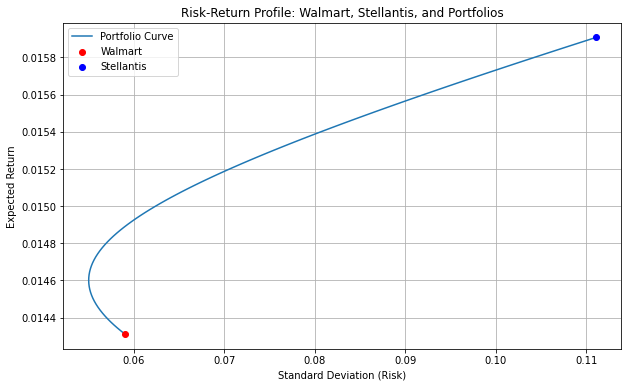

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Portfolio Curve')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.title('Risk-Return Profile: Walmart, Stellantis, and Portfolios')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## S: the best efficient portfolio

In [27]:
risk_free_rate = 0.0427/12  

portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)

sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_stds

max_sharpe_idx = sharpe_ratios.argmax()
optimal_risky_portfolio_return = portfolio_returns[max_sharpe_idx]
optimal_risky_portfolio_std = portfolio_stds[max_sharpe_idx]

cml_x = np.linspace(0, max(portfolio_stds), 100)
cml_y = risk_free_rate + (optimal_risky_portfolio_return - risk_free_rate) / optimal_risky_portfolio_std * cml_x


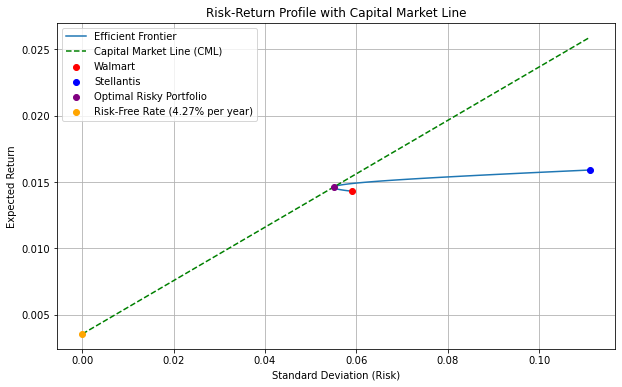

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Efficient Frontier')
plt.plot(cml_x, cml_y, label='Capital Market Line (CML)', linestyle='--', color='green')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.scatter(optimal_risky_portfolio_std, optimal_risky_portfolio_return, color='purple', label='Optimal Risky Portfolio', zorder=5)
plt.scatter(0, risk_free_rate, color='orange', label='Risk-Free Rate (4.27% per year)', zorder=5)
plt.title('Risk-Return Profile with Capital Market Line')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()